# GNN runner
## Mark Tenzer & Jimmy Howerton
## Adapted from code provided with the Spektral package, cited below:
https://github.com/danielegrattarola/spektral/blob/master/examples/node_prediction/citation_gcn.py


# Imports

In [22]:
# Base python
import pickle # for loading sparse matrix from disk
import gc     # for garbage collection (RAM management/cleanup)

# Common scientific packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

# TF imports
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dropout, BatchNormalization, Dense, Activation, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Spektral imports for GNN
from spektral.layers import GraphConv, GraphSageConv, GINConv

# Config

In [2]:
# Type of graph convolution
Conv = GraphConv

# File location to save model
modelfile = "GCN-DNN-2015.h5"

# Number of graph convolution layers
n_layers = 5

# Number of channels at each conv
channels = 64

# Adjacency matrix of choice
adj_file = "Aboth.pkl"

# Maximum number of training epochs
epochs = 500

# Dropout rate
# dropout_rate = 0.5

# Read the adjacency matrix $A$

#### Load $A$ from disk

In [3]:
with open(adj_file, 'rb') as f:
    A = pickle.load(f)

#### Preprocess $A$ as needed for this GNN convolution technique

In [4]:
fltr = Conv.preprocess(A.astype('float32'))

# Read the data

#### Initial read of file

In [5]:
data = pd.read_csv('/mnt/d/wildfires/fires_merged_weather.csv', index_col=0,
                  #dtype for smaller representation
                  dtype={#'STAT_CAUSE_DESCR': 'category', 'STATE': 'category', 'DISCOVERY_MONTH': 'category',
                        'Fog': 'bool', 'FunnelCloud': 'bool', 'Hail': 'bool', 'Rain': 'bool',
                        'Snow': 'bool', 'Thunder': 'bool'}
                  )

/home/mark/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/mark/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


#### Drop unnecessary columns

In [6]:
data.drop(['Unnamed: 0.1', 'index_x', 'FOD_ID', 'FIRE_NAME', 'DISCOVERY_DOY_SCALED',
           'x_fire', 'y_fire', 'z_fire',
           'index_y', 'Begin', 'End', 'Country', 'Day', 'ICAO', 'Latitude', 'Longitude', 'Month', 'STATION NAME',
           'State', 'Station', 'USAF', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 
           'WBAN', 'Year', 'doy', 'x', 'y', 'z',
          ],
         axis='columns', inplace=True)

#### Just 2015 data

In [7]:
data = data[data.FIRE_YEAR == 2015]

#### Cleanup memory

In [8]:
gc.collect()

251

# Preprocess the data

Perform imputation as appropriate; split into train/validation sets.

#### Split into features and labels

In [9]:
Y = pd.get_dummies(data['STAT_CAUSE_DESCR'])
X = pd.get_dummies(data.drop('STAT_CAUSE_DESCR', axis='columns'))

# Number of examples
N = X.shape[0]
# Number of features
F = X.shape[1]

#### Find the missing values, and set to NA

In [10]:
for na in [9999.9, 999.9, 99.99]:
    X[X == na] = np.nan

#### Zero-imputing for some features -- see EDA.ipynb

In [11]:
for zcol in ['Gust', 'MaxWindspeed', 'Precip', 'SnowDepth', 'Visibility', 'Windspeed']:
    X.loc[X[zcol].isna(), zcol] = 0

# Split into training/testing

We'll have three sets of nodes: training nodes, validation nodes, and censored nodes (nodes without valid labels).  Note that this is a semi-supervised problem.

#### Determine which nodes lack valid labels

In [12]:
# Determing which fires fit in these categories
censor = (data['STAT_CAUSE_DESCR'] == 'Missing/Undefined') | (data['STAT_CAUSE_DESCR'] == 'Miscellaneous')

# Drop these levels from the label
Y = Y.drop(['Missing/Undefined', 'Miscellaneous'], axis='columns').values

# Number of classes left
n_classes = Y.shape[1]

In [13]:
labeled_ind  = np.arange(data.shape[0])[~censor]
censor_ind = np.arange(data.shape[0])[censor ]

#### Determine which nodes lack valid labels

In [14]:
train_ind, val_ind = train_test_split(labeled_ind, test_size=0.1, random_state=42)

# "Masks" for training and validation: 1 if in the given set, 0 if not (or no label)
train_mask = np.zeros(N)
train_mask[train_ind] = 1

val_mask = np.zeros(N)
val_mask[val_ind] = 1

#### Mean imputation for the other features -- see EDA.ipynb

In [15]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

In [16]:
# Make sure to fit only on the training data!  Otherwise the imputation introduces bias
imp.fit(X.values[train_ind, :])

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [17]:
# Impute the training and testing values
X = imp.transform(X)

# Define the model

### Model definition

In [43]:
# Input
X_in = Input(shape=(F, ))           # features  for this node
fltr_in = Input((N, ), sparse=True) # adjacency for this node

currentX = X_in

# For each of the specified layers,
for _ in range(n_layers):

    # Dropout the current layer's inputs
    #currentX = Dropout(dropout_rate)(currentX)
    
    # Graph convolution -- Note that "Conv" type was specified in Config section
    currentX = Conv(channels,
                      activation='relu',
                      #kernel_regularizer=l2(0.1),
                      #use_bias=False
                     )([currentX, fltr_in])
    
    #currentX = BatchNormalization()(currentX)

# Dense Neural Network

print(currentX.shape)

for _ in range(3):
    #currentX = Dropout(dropout_rate)(currentX)

    currentX = Dense(64, activation='relu')(currentX)
    #currentX = BatchNormalization()(currentX)
    #currentX = Activation('relu')(currentX)
    
# Final layer
output = Dense(Y.shape[1], activation='softmax')(currentX)

(None, 64)


### Model setup

In [44]:
# Build model
model = Model(inputs=[X_in, fltr_in], outputs=output)
model.compile(optimizer=Adam(1e-2),
              loss='categorical_crossentropy',
              weighted_metrics=['categorical_accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 83)]         0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
graph_conv_85 (GraphConv)       (None, 64)           5376        input_35[0][0]                   
                                                                 input_36[0][0]                   
__________________________________________________________________________________________________
graph_conv_86 (GraphConv)       (None, 64)           4160        graph_conv_85[0][0]        

# Model fitting

In [45]:
# Define validation data
validation_data = ([X, fltr], Y, val_mask)

history = model.fit([X, fltr],
          Y,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,  # Shuffling data means shuffling the whole graph
          callbacks=[
              EarlyStopping(patience=50,  restore_best_weights=True)
          ])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 74491 samples, validate on 74491 samples
Epoch 1/500
74491/74491 [==============================] - 4s 56us/sample - loss: 14.1735 - categorical_accuracy: 0.0279 - val_loss: 1.0354 - val_categorical_accuracy: 0.3016
Epoch 2/500
74491/74491 [==============================] - 2s 33us/sample - loss: 9.3773 - categorical_accuracy: 0.3061 - val_loss: 0.3295 - val_categorical_accuracy: 0.1942
Epoch 3/500
74491/74491 [==============================] - 3s 34us/sample - loss: 2.9905 - categorical_accuracy: 0.1884 - val_loss: 0.4520 - val_categorical_accuracy: 0.1076
Epoch 4/500
74491/74491 [==============================] - 3s 35us/sample - loss: 4.0837 - categorical_accuracy: 0.1095 - val_loss: 0.3754 - val_categorical_accuracy: 0.3868
Epoch 5/500
74491/74491 [==============================] - 2s 32us/sample - loss: 3.4602 - categorical_accuracy: 0.3802 - val_loss: 0.4063 - val_categorical_accuracy: 0.2020
Epoch 6/500
74491/74491 [====

# Plot training history

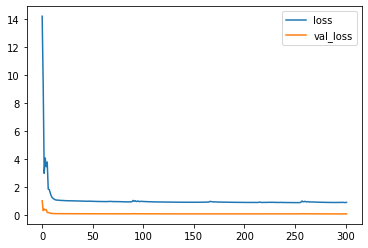

In [46]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.legend()
plt.show()

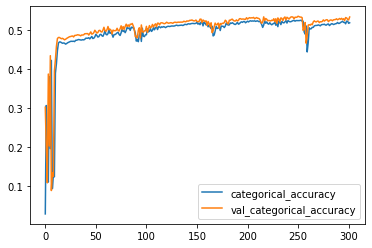

In [47]:
fig, ax = plt.subplots()
ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
ax.plot(history.history['val_categorical_accuracy'], label='val_categorical_accuracy')
ax.legend()
plt.show()

# Save model to disk

In [49]:
model.save(modelfile)